In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

RANDOM_STATE = 42

In [2]:
base = "./Dataset/_outputs_train_val_test/"
# ----------------------------
# 1) Load data
# ----------------------------
X_train = sp.load_npz(base + "X_train_bow.npz")
X_val   = sp.load_npz(base + "X_val_bow.npz")
X_test  = sp.load_npz(base + "X_test_bow.npz")

y_train = pd.read_csv(base + "train.csv")["label"].values
y_val   = pd.read_csv(base + "val.csv")["label"].values
y_test  = pd.read_csv(base + "test.csv")["label"].values

print("Shapes:",
      "X_train", X_train.shape,
      "X_val", X_val.shape,
      "X_test", X_test.shape)

Shapes: X_train (13938, 8508) X_val (1549, 8508) X_test (3872, 8508)


In [3]:
# ----------------------------
# 2) Helpers
# ----------------------------
def eval_binary(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return acc, p, r, f1

def run_model(name, model, X_tr, y_tr, X_va, y_va, X_te, y_te, show_reports=False):
    print(f"\n=== {name} ===")
    model.fit(X_tr, y_tr)

    yv = model.predict(X_va)
    yt = model.predict(X_te)

    acc_v, p_v, r_v, f1_v = eval_binary(y_va, yv)
    acc_t, p_t, r_t, f1_t = eval_binary(y_te, yt)

    print(f"[VAL ] Acc={acc_v:.4f}  P={p_v:.4f}  R={r_v:.4f}  F1={f1_v:.4f}")
    print(f"[TEST] Acc={acc_t:.4f}  P={p_t:.4f}  R={r_t:.4f}  F1={f1_t:.4f}")

    if show_reports:
        print("\n[VAL] classification_report:\n", classification_report(y_va, yv, digits=4, zero_division=0))
        print("[VAL] confusion_matrix:\n", confusion_matrix(y_va, yv))
        print("\n[TEST] classification_report:\n", classification_report(y_te, yt, digits=4, zero_division=0))
        print("[TEST] confusion_matrix:\n", confusion_matrix(y_te, yt))

    return {
        "model": name,
        "val_acc": acc_v, "val_prec": p_v, "val_rec": r_v, "val_f1": f1_v,
        "test_acc": acc_t, "test_prec": p_t, "test_rec": r_t, "test_f1": f1_t,
    }


In [4]:
# ----------------------------
# 3) Train & evaluate models
# ----------------------------
results = []

# 3.1 Logistic Regression (full BoW sparse)
lr = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
results.append(run_model("Logistic Regression (BoW full)", lr,
                         X_train, y_train, X_val, y_val, X_test, y_test))

# 3.2 Linear SVM (full BoW sparse)
svm = LinearSVC(
    class_weight="balanced",
    random_state=RANDOM_STATE
)
results.append(run_model("Linear SVM (BoW full)", svm,
                         X_train, y_train, X_val, y_val, X_test, y_test))

# 3.3 Feature selection for tree-based models
#     (Tree/RF thường hợp hơn với số feature vừa phải)
TOP_K = 500  # bạn có thể thử 300/500/1000/2000

selector = SelectKBest(score_func=chi2, k=min(TOP_K, X_train.shape[1]))
X_train_k = selector.fit_transform(X_train, y_train)
X_val_k   = selector.transform(X_val)
X_test_k  = selector.transform(X_test)

print(f"\nChi2 feature selection: k={selector.k}, X_train_k={X_train_k.shape}")

# 3.4 Decision Tree
dt = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
results.append(run_model(f"Decision Tree (chi2 k={selector.k})", dt,
                         X_train_k, y_train, X_val_k, y_val, X_test_k, y_test))

# 3.5 Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
results.append(run_model(f"Random Forest (chi2 k={selector.k})", rf,
                         X_train_k, y_train, X_val_k, y_val, X_test_k, y_test))


=== Logistic Regression (BoW full) ===
[VAL ] Acc=0.9961  P=0.9949  R=0.9949  F1=0.9949
[TEST] Acc=0.9959  P=0.9959  R=0.9932  F1=0.9945

=== Linear SVM (BoW full) ===
[VAL ] Acc=0.9974  P=0.9983  R=0.9949  F1=0.9966
[TEST] Acc=0.9964  P=0.9952  R=0.9952  F1=0.9952

Chi2 feature selection: k=500, X_train_k=(13938, 500)

=== Decision Tree (chi2 k=500) ===
[VAL ] Acc=0.9987  P=0.9983  R=0.9983  F1=0.9983
[TEST] Acc=0.9910  P=0.9864  R=0.9898  F1=0.9881

=== Random Forest (chi2 k=500) ===
[VAL ] Acc=0.9994  P=1.0000  R=0.9983  F1=0.9991
[TEST] Acc=0.9946  P=0.9938  R=0.9918  F1=0.9928


In [5]:
# ----------------------------
# 4) Summary table
# ----------------------------
df_res = pd.DataFrame(results)
df_res = df_res[[
    "model",
    "val_acc","val_prec","val_rec","val_f1",
    "test_acc","test_prec","test_rec","test_f1"
]].sort_values(by="test_f1", ascending=False)

print("\n\n===== SUMMARY (sorted by TEST F1) =====")
print(df_res.to_string(index=False, float_format=lambda x: f"{x:.4f}"))



===== SUMMARY (sorted by TEST F1) =====
                         model  val_acc  val_prec  val_rec  val_f1  test_acc  test_prec  test_rec  test_f1
         Linear SVM (BoW full)   0.9974    0.9983   0.9949  0.9966    0.9964     0.9952    0.9952   0.9952
Logistic Regression (BoW full)   0.9961    0.9949   0.9949  0.9949    0.9959     0.9959    0.9932   0.9945
    Random Forest (chi2 k=500)   0.9994    1.0000   0.9983  0.9991    0.9946     0.9938    0.9918   0.9928
    Decision Tree (chi2 k=500)   0.9987    0.9983   0.9983  0.9983    0.9910     0.9864    0.9898   0.9881


In [29]:
# ----------------------------
# 5) Zoomed bar charts (VAL & TEST) from df_res
# ----------------------------
import numpy as np
import matplotlib.pyplot as plt

def plot_zoom_bars(df, prefix="val", title="VAL metrics (zoomed)", decimals=4, pad_ratio=0.25):
    """
    df: dataframe có các cột:
        model, {prefix}_acc, {prefix}_prec, {prefix}_rec, {prefix}_f1
    prefix: "val" hoặc "test"
    """
    metric_cols = [f"{prefix}_acc", f"{prefix}_prec", f"{prefix}_rec", f"{prefix}_f1"]
    metric_labels = ["Accuracy", "Precision", "Recall", "F1"]

    # Ensure ordering follows df rows
    models = df["model"].tolist()
    data = df[metric_cols].to_numpy(dtype=float)

    # auto-zoom y-limits
    vmin = float(np.min(data))
    vmax = float(np.max(data))
    span = max(1e-6, 1.0 - vmin)
    pad = max(1e-4, span * pad_ratio)
    ymin = max(0.0, vmin - pad)
    ymax = 1.0

    x = np.arange(len(models))
    width = 0.18

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (lab, col_idx) in enumerate(zip(metric_labels, range(data.shape[1]))):
        vals = data[:, col_idx]
        bars = ax.bar(x + (i - 1.5) * width, vals, width, label=lab)

        # value labels
        fmt = "{:." + str(decimals) + "f}"
        for b, v in zip(bars, vals):
            ax.text(
                b.get_x() + b.get_width() / 2,
                v,
                fmt.format(v),
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=0
            )

    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in models], fontsize=10)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(0.96, 1.00, 0.01))
    ax.grid(axis="y", alpha=0.35)
    ax.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.18))
    fig.tight_layout()
    return fig, ax


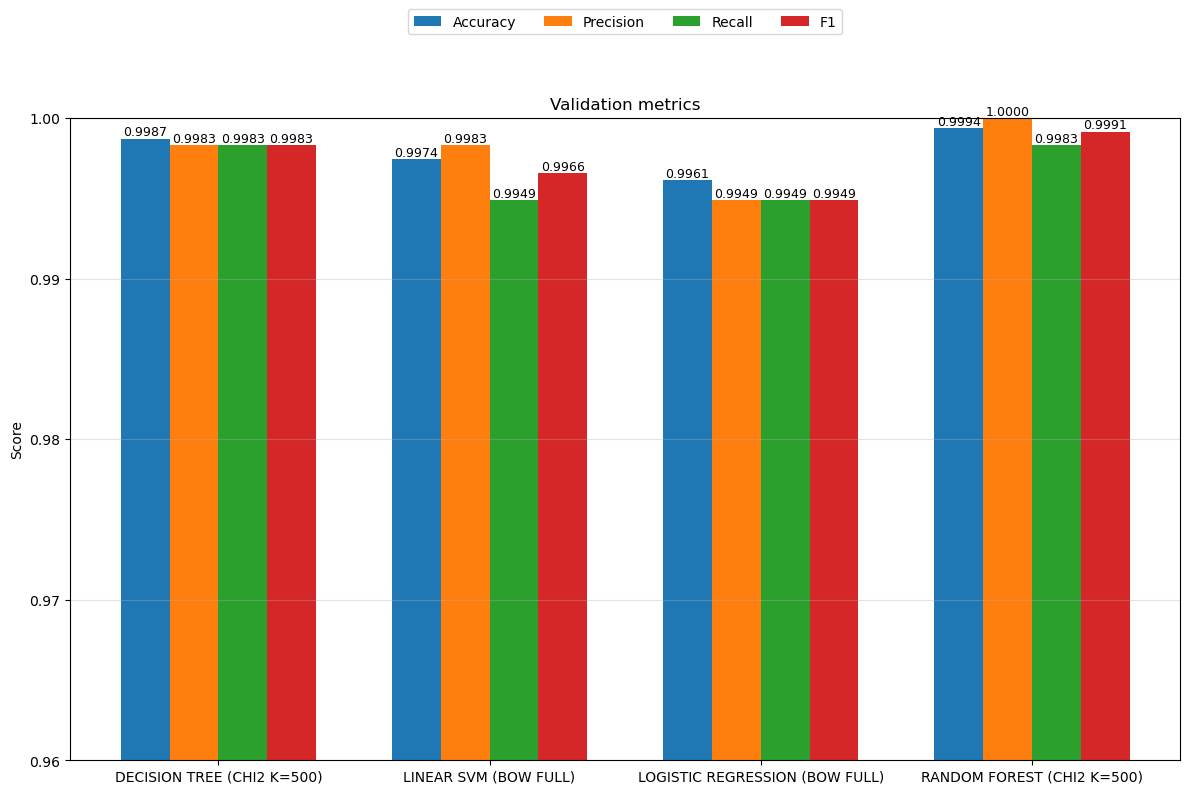

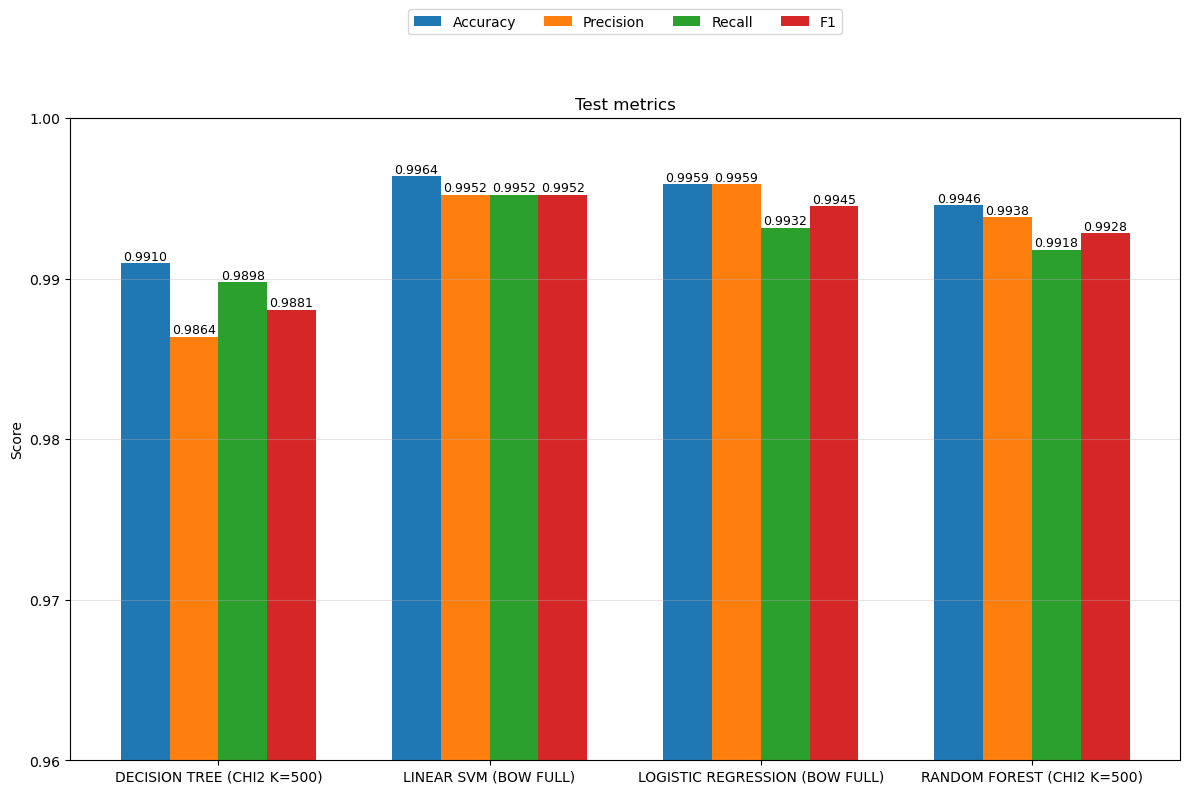

In [30]:
order = [
    "Decision Tree (chi2 k=500)",
    "Linear SVM (BoW full)",
    "Logistic Regression (BoW full)",
    "Random Forest (chi2 k=500)",
]
df_plot = df_res.set_index("model").loc[order].reset_index()

plot_zoom_bars(df_plot, prefix="val", title="Validation metrics")
plt.show()
plot_zoom_bars(df_plot, prefix="test", title="Test metrics")
plt.show()